In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

In [4]:
lonMin = (float)(config['REGION']['LON_MIN'])
lonMax = (float)(config['REGION']['LON_MAX'])

latMin = (float)(config['REGION']['LAT_MIN'])
latMax = (float)(config['REGION']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['HEATMAP']['INCR_STEP'])
incrRes = (int)(config['HEATMAP']['INCR_RES'])

-120.0 34.12
-119.5 34.24


In [5]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)

In [6]:
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]

In [7]:
fileDir = "../Data/M120_00_M190_50_34_12_34_24/HalfHourlyLE/"
dirToStore = "../Data/M120_00_M190_50_34_12_34_24/HalfHourlyTP/"

In [8]:
#1 to load existing data
loadExisting = 1
neighTPCount = []
for i in range(horizontalAxis.shape[0] * verticalAxis.shape[0]):
    fileToRead = dirToStore + str(i) + '.npy'
    if(loadExisting == 1):
        neighTPCount.append(np.load(fileToRead))
    else:
        neighTPCount.append(np.zeros((horizontalAxis.shape[0] * verticalAxis.shape[0])))

In [9]:
def get_index_from_lon_lat(lon,lat):
    retVal = -1
    for boundary in boundaryArray: 
        if(lon >= boundary[0]) and (lon < boundary[1]) \
            and (lat >= boundary[2]) and (lat < boundary[3]):
            retVal = boundary[4]
            break 
    return retVal

In [10]:
def clear_tm_matrix():
    for i in range(horizontalAxis.shape[0] * verticalAxis.shape[0]):
        neighTPCount[i].fill(0)
        
def compute_transition_prob(firstNum):
    fileName1 = fileDir + str(firstNum) + '.csv'
    fileName2 = fileDir + str(firstNum+1) + '.csv'

    #transition probability for first hour
    firstDF,_ = aISDM.load_data_from_csv(fileName1)
    #transition probability for next hour
    secondDF,_ = aISDM.load_data_from_csv(fileName2)
    
    #vessels in current hour
    currVessels = aISDM.get_list_of_unique_mmsi(firstDF)
    #vessels in next hour
    nextVessels = aISDM.get_list_of_unique_mmsi(secondDF)
    
    firstDF = firstDF.set_index('MMSI')
    secondDF = secondDF.set_index('MMSI')
    #compute vessels of interest
    #this are vessels which are of interest
    vesselsOfInterest = list(set(currVessels) & set(nextVessels))
    #iterate through every vessel
    #get the first LON and LAT coordinate for the first vessel
    for vessel in vesselsOfInterest:
        #get the LON and LAT value of the vessel
        #get the location where vessel is present
        #now we have the location
        vesselCurrIndex = get_index_from_lon_lat(firstDF.loc[vessel,'LON'],firstDF.loc[vessel,'LAT'])
        #now lets findout where this vessel is
        vesselNextIndex = get_index_from_lon_lat(secondDF.loc[vessel,'LON'],secondDF.loc[vessel,'LAT'])
        neighTPCount[vesselNextIndex][vesselCurrIndex] = neighTPCount[vesselNextIndex][vesselCurrIndex] + 1

In [11]:
# clear_tm_matrix()
# compute_transition_prob(55)

In [13]:
clear_tm_matrix()

In [14]:
for fileCounter in range(17519):
    try:
        compute_transition_prob(fileCounter)
        print("Done Computing %d"%(fileCounter))
    except KeyboardInterrupt:
        break

Done Computing 0
Done Computing 1
Done Computing 2
Done Computing 3
Done Computing 4
Done Computing 5
Done Computing 6
Done Computing 7
Done Computing 8
Done Computing 9
Done Computing 10
Done Computing 11
Done Computing 12
Done Computing 13
Done Computing 14
Done Computing 15
Done Computing 16
Done Computing 17
Done Computing 18
Done Computing 19
Done Computing 20
Done Computing 21
Done Computing 22
Done Computing 23
Done Computing 24
Done Computing 25
Done Computing 26
Done Computing 27
Done Computing 28
Done Computing 29
Done Computing 30
Done Computing 31
Done Computing 32
Done Computing 33
Done Computing 34
Done Computing 35
Done Computing 36
Done Computing 37
Done Computing 38
Done Computing 39
Done Computing 40
Done Computing 41
Done Computing 42
Done Computing 43
Done Computing 44
Done Computing 45
Done Computing 46
Done Computing 47
Done Computing 48
Done Computing 49
Done Computing 50
Done Computing 51
Done Computing 52
Done Computing 53
Done Computing 54
Done Computing 55
Do

Done Computing 440
Done Computing 441
Done Computing 442
Done Computing 443
Done Computing 444
Done Computing 445
Done Computing 446
Done Computing 447
Done Computing 448
Done Computing 449
Done Computing 450
Done Computing 451
Done Computing 452
Done Computing 453
Done Computing 454
Done Computing 455
Done Computing 456
Done Computing 457
Done Computing 458
Done Computing 459
Done Computing 460
Done Computing 461
Done Computing 462
Done Computing 463
Done Computing 464
Done Computing 465
Done Computing 466
Done Computing 467
Done Computing 468
Done Computing 469
Done Computing 470
Done Computing 471
Done Computing 472
Done Computing 473
Done Computing 474
Done Computing 475
Done Computing 476
Done Computing 477
Done Computing 478
Done Computing 479
Done Computing 480
Done Computing 481
Done Computing 482
Done Computing 483
Done Computing 484
Done Computing 485
Done Computing 486
Done Computing 487
Done Computing 488
Done Computing 489
Done Computing 490
Done Computing 491
Done Computi

Done Computing 883
Done Computing 884
Done Computing 885
Done Computing 886
Done Computing 887
Done Computing 888
Done Computing 889
Done Computing 890
Done Computing 891
Done Computing 892
Done Computing 893
Done Computing 894
Done Computing 895
Done Computing 896
Done Computing 897
Done Computing 898
Done Computing 899
Done Computing 900
Done Computing 901
Done Computing 902
Done Computing 903
Done Computing 904
Done Computing 905
Done Computing 906
Done Computing 907
Done Computing 908
Done Computing 909
Done Computing 910
Done Computing 911
Done Computing 912
Done Computing 913
Done Computing 914
Done Computing 915
Done Computing 916
Done Computing 917
Done Computing 918
Done Computing 919
Done Computing 920
Done Computing 921
Done Computing 922
Done Computing 923
Done Computing 924
Done Computing 925
Done Computing 926
Done Computing 927
Done Computing 928
Done Computing 929
Done Computing 930
Done Computing 931
Done Computing 932
Done Computing 933
Done Computing 934
Done Computi

Done Computing 1322
Done Computing 1323
Done Computing 1324
Done Computing 1325
Done Computing 1326
Done Computing 1327
Done Computing 1328
Done Computing 1329
Done Computing 1330
Done Computing 1331
Done Computing 1332
Done Computing 1333
Done Computing 1334
Done Computing 1335
Done Computing 1336
Done Computing 1337
Done Computing 1338
Done Computing 1339
Done Computing 1340
Done Computing 1341
Done Computing 1342
Done Computing 1343
Done Computing 1344
Done Computing 1345
Done Computing 1346
Done Computing 1347
Done Computing 1348
Done Computing 1349
Done Computing 1350
Done Computing 1351
Done Computing 1352
Done Computing 1353
Done Computing 1354
Done Computing 1355
Done Computing 1356
Done Computing 1357
Done Computing 1358
Done Computing 1359
Done Computing 1360
Done Computing 1361
Done Computing 1362
Done Computing 1363
Done Computing 1364
Done Computing 1365
Done Computing 1366
Done Computing 1367
Done Computing 1368
Done Computing 1369
Done Computing 1370
Done Computing 1371


Done Computing 1775
Done Computing 1776
Done Computing 1777
Done Computing 1778
Done Computing 1779
Done Computing 1780
Done Computing 1781
Done Computing 1782
Done Computing 1783
Done Computing 1784
Done Computing 1785
Done Computing 1786
Done Computing 1787
Done Computing 1788
Done Computing 1789
Done Computing 1790
Done Computing 1791
Done Computing 1792
Done Computing 1793
Done Computing 1794
Done Computing 1795
Done Computing 1796
Done Computing 1797
Done Computing 1798
Done Computing 1799
Done Computing 1800
Done Computing 1801
Done Computing 1802
Done Computing 1803
Done Computing 1804
Done Computing 1805
Done Computing 1806
Done Computing 1807
Done Computing 1808
Done Computing 1809
Done Computing 1810
Done Computing 1811
Done Computing 1812
Done Computing 1813
Done Computing 1814
Done Computing 1815
Done Computing 1816
Done Computing 1817
Done Computing 1818
Done Computing 1819
Done Computing 1820
Done Computing 1821
Done Computing 1822
Done Computing 1823
Done Computing 1824


Done Computing 2223
Done Computing 2224
Done Computing 2225
Done Computing 2226
Done Computing 2227
Done Computing 2228
Done Computing 2229
Done Computing 2230
Done Computing 2231
Done Computing 2232
Done Computing 2233
Done Computing 2234
Done Computing 2235
Done Computing 2236
Done Computing 2237
Done Computing 2238
Done Computing 2239
Done Computing 2240
Done Computing 2241
Done Computing 2242
Done Computing 2243
Done Computing 2244
Done Computing 2245
Done Computing 2246
Done Computing 2247
Done Computing 2248
Done Computing 2249
Done Computing 2250
Done Computing 2251
Done Computing 2252
Done Computing 2253
Done Computing 2254
Done Computing 2255
Done Computing 2256
Done Computing 2257
Done Computing 2258
Done Computing 2259
Done Computing 2260
Done Computing 2261
Done Computing 2262
Done Computing 2263
Done Computing 2264
Done Computing 2265
Done Computing 2266
Done Computing 2267
Done Computing 2268
Done Computing 2269
Done Computing 2270
Done Computing 2271
Done Computing 2272


Done Computing 2670
Done Computing 2671
Done Computing 2672
Done Computing 2673
Done Computing 2674
Done Computing 2675
Done Computing 2676
Done Computing 2677
Done Computing 2678
Done Computing 2679
Done Computing 2680
Done Computing 2681
Done Computing 2682
Done Computing 2683
Done Computing 2684
Done Computing 2685
Done Computing 2686
Done Computing 2687
Done Computing 2688
Done Computing 2689
Done Computing 2690
Done Computing 2691
Done Computing 2692
Done Computing 2693
Done Computing 2694
Done Computing 2695
Done Computing 2696
Done Computing 2697
Done Computing 2698
Done Computing 2699
Done Computing 2700
Done Computing 2701
Done Computing 2702
Done Computing 2703
Done Computing 2704
Done Computing 2705
Done Computing 2706
Done Computing 2707
Done Computing 2708
Done Computing 2709
Done Computing 2710
Done Computing 2711
Done Computing 2712
Done Computing 2713
Done Computing 2714
Done Computing 2715
Done Computing 2716
Done Computing 2717
Done Computing 2718
Done Computing 2719


Done Computing 3115
Done Computing 3116
Done Computing 3117
Done Computing 3118
Done Computing 3119
Done Computing 3120
Done Computing 3121
Done Computing 3122
Done Computing 3123
Done Computing 3124
Done Computing 3125
Done Computing 3126
Done Computing 3127
Done Computing 3128
Done Computing 3129
Done Computing 3130
Done Computing 3131
Done Computing 3132
Done Computing 3133
Done Computing 3134
Done Computing 3135
Done Computing 3136
Done Computing 3137
Done Computing 3138
Done Computing 3139
Done Computing 3140
Done Computing 3141
Done Computing 3142
Done Computing 3143
Done Computing 3144
Done Computing 3145
Done Computing 3146
Done Computing 3147
Done Computing 3148
Done Computing 3149
Done Computing 3150
Done Computing 3151
Done Computing 3152
Done Computing 3153
Done Computing 3154
Done Computing 3155
Done Computing 3156
Done Computing 3157
Done Computing 3158
Done Computing 3159
Done Computing 3160
Done Computing 3161
Done Computing 3162
Done Computing 3163
Done Computing 3164


Done Computing 3548
Done Computing 3549
Done Computing 3550
Done Computing 3551
Done Computing 3552
Done Computing 3553
Done Computing 3554
Done Computing 3555
Done Computing 3556
Done Computing 3557
Done Computing 3558
Done Computing 3559
Done Computing 3560
Done Computing 3561
Done Computing 3562
Done Computing 3563
Done Computing 3564
Done Computing 3565
Done Computing 3566
Done Computing 3567
Done Computing 3568
Done Computing 3569
Done Computing 3570
Done Computing 3571
Done Computing 3572
Done Computing 3573
Done Computing 3574
Done Computing 3575
Done Computing 3576
Done Computing 3577
Done Computing 3578
Done Computing 3579
Done Computing 3580
Done Computing 3581
Done Computing 3582
Done Computing 3583
Done Computing 3584
Done Computing 3585
Done Computing 3586
Done Computing 3587
Done Computing 3588
Done Computing 3589
Done Computing 3590
Done Computing 3591
Done Computing 3592
Done Computing 3593
Done Computing 3594
Done Computing 3595
Done Computing 3596
Done Computing 3597


Done Computing 3983
Done Computing 3984
Done Computing 3985
Done Computing 3986
Done Computing 3987
Done Computing 3988
Done Computing 3989
Done Computing 3990
Done Computing 3991
Done Computing 3992
Done Computing 3993
Done Computing 3994
Done Computing 3995
Done Computing 3996
Done Computing 3997
Done Computing 3998
Done Computing 3999
Done Computing 4000
Done Computing 4001
Done Computing 4002
Done Computing 4003
Done Computing 4004
Done Computing 4005
Done Computing 4006
Done Computing 4007
Done Computing 4008
Done Computing 4009
Done Computing 4010
Done Computing 4011
Done Computing 4012
Done Computing 4013
Done Computing 4014
Done Computing 4015
Done Computing 4016
Done Computing 4017
Done Computing 4018
Done Computing 4019
Done Computing 4020
Done Computing 4021
Done Computing 4022
Done Computing 4023
Done Computing 4024
Done Computing 4025
Done Computing 4026
Done Computing 4027
Done Computing 4028
Done Computing 4029
Done Computing 4030
Done Computing 4031
Done Computing 4032


Done Computing 4422
Done Computing 4423
Done Computing 4424
Done Computing 4425
Done Computing 4426
Done Computing 4427
Done Computing 4428
Done Computing 4429
Done Computing 4430
Done Computing 4431
Done Computing 4432
Done Computing 4433
Done Computing 4434
Done Computing 4435
Done Computing 4436
Done Computing 4437
Done Computing 4438
Done Computing 4439
Done Computing 4440
Done Computing 4441
Done Computing 4442
Done Computing 4443
Done Computing 4444
Done Computing 4445
Done Computing 4446
Done Computing 4447
Done Computing 4448
Done Computing 4449
Done Computing 4450
Done Computing 4451
Done Computing 4452
Done Computing 4453
Done Computing 4454
Done Computing 4455
Done Computing 4456
Done Computing 4457
Done Computing 4458
Done Computing 4459
Done Computing 4460
Done Computing 4461
Done Computing 4462
Done Computing 4463
Done Computing 4464
Done Computing 4465
Done Computing 4466
Done Computing 4467
Done Computing 4468
Done Computing 4469
Done Computing 4470
Done Computing 4471


Done Computing 4857
Done Computing 4858
Done Computing 4859
Done Computing 4860
Done Computing 4861
Done Computing 4862
Done Computing 4863
Done Computing 4864
Done Computing 4865
Done Computing 4866
Done Computing 4867
Done Computing 4868
Done Computing 4869
Done Computing 4870
Done Computing 4871
Done Computing 4872
Done Computing 4873
Done Computing 4874
Done Computing 4875
Done Computing 4876
Done Computing 4877
Done Computing 4878
Done Computing 4879
Done Computing 4880
Done Computing 4881
Done Computing 4882
Done Computing 4883
Done Computing 4884
Done Computing 4885
Done Computing 4886
Done Computing 4887
Done Computing 4888
Done Computing 4889
Done Computing 4890
Done Computing 4891
Done Computing 4892
Done Computing 4893
Done Computing 4894
Done Computing 4895
Done Computing 4896
Done Computing 4897
Done Computing 4898
Done Computing 4899
Done Computing 4900
Done Computing 4901
Done Computing 4902
Done Computing 4903
Done Computing 4904
Done Computing 4905
Done Computing 4906


Done Computing 5310
Done Computing 5311
Done Computing 5312
Done Computing 5313
Done Computing 5314
Done Computing 5315
Done Computing 5316
Done Computing 5317
Done Computing 5318
Done Computing 5319
Done Computing 5320
Done Computing 5321
Done Computing 5322
Done Computing 5323
Done Computing 5324
Done Computing 5325
Done Computing 5326
Done Computing 5327
Done Computing 5328
Done Computing 5329
Done Computing 5330
Done Computing 5331
Done Computing 5332
Done Computing 5333
Done Computing 5334
Done Computing 5335
Done Computing 5336
Done Computing 5337
Done Computing 5338
Done Computing 5339
Done Computing 5340
Done Computing 5341
Done Computing 5342
Done Computing 5343
Done Computing 5344
Done Computing 5345
Done Computing 5346
Done Computing 5347
Done Computing 5348
Done Computing 5349
Done Computing 5350
Done Computing 5351
Done Computing 5352
Done Computing 5353
Done Computing 5354
Done Computing 5355
Done Computing 5356
Done Computing 5357
Done Computing 5358
Done Computing 5359


Done Computing 5738
Done Computing 5739
Done Computing 5740
Done Computing 5741
Done Computing 5742
Done Computing 5743
Done Computing 5744
Done Computing 5745
Done Computing 5746
Done Computing 5747
Done Computing 5748
Done Computing 5749
Done Computing 5750
Done Computing 5751
Done Computing 5752
Done Computing 5753
Done Computing 5754
Done Computing 5755
Done Computing 5756
Done Computing 5757
Done Computing 5758
Done Computing 5759
Done Computing 5760
Done Computing 5761
Done Computing 5762
Done Computing 5763
Done Computing 5764
Done Computing 5765
Done Computing 5766
Done Computing 5767
Done Computing 5768
Done Computing 5769
Done Computing 5770
Done Computing 5771
Done Computing 5772
Done Computing 5773
Done Computing 5774
Done Computing 5775
Done Computing 5776
Done Computing 5777
Done Computing 5778
Done Computing 5779
Done Computing 5780
Done Computing 5781
Done Computing 5782
Done Computing 5783
Done Computing 5784
Done Computing 5785
Done Computing 5786
Done Computing 5787


Done Computing 6166
Done Computing 6167
Done Computing 6168
Done Computing 6169
Done Computing 6170
Done Computing 6171
Done Computing 6172
Done Computing 6173
Done Computing 6174
Done Computing 6175
Done Computing 6176
Done Computing 6177
Done Computing 6178
Done Computing 6179
Done Computing 6180
Done Computing 6181
Done Computing 6182
Done Computing 6183
Done Computing 6184
Done Computing 6185
Done Computing 6186
Done Computing 6187
Done Computing 6188
Done Computing 6189
Done Computing 6190
Done Computing 6191
Done Computing 6192
Done Computing 6193
Done Computing 6194
Done Computing 6195
Done Computing 6196
Done Computing 6197
Done Computing 6198
Done Computing 6199
Done Computing 6200
Done Computing 6201
Done Computing 6202
Done Computing 6203
Done Computing 6204
Done Computing 6205
Done Computing 6206
Done Computing 6207
Done Computing 6208
Done Computing 6209
Done Computing 6210
Done Computing 6211
Done Computing 6212
Done Computing 6213
Done Computing 6214
Done Computing 6215


Done Computing 6620
Done Computing 6621
Done Computing 6622
Done Computing 6623
Done Computing 6624
Done Computing 6625
Done Computing 6626
Done Computing 6627
Done Computing 6628
Done Computing 6629
Done Computing 6630
Done Computing 6631
Done Computing 6632
Done Computing 6633
Done Computing 6634
Done Computing 6635
Done Computing 6636
Done Computing 6637
Done Computing 6638
Done Computing 6639
Done Computing 6640
Done Computing 6641
Done Computing 6642
Done Computing 6643
Done Computing 6644
Done Computing 6645
Done Computing 6646
Done Computing 6647
Done Computing 6648
Done Computing 6649
Done Computing 6650
Done Computing 6651
Done Computing 6652
Done Computing 6653
Done Computing 6654
Done Computing 6655
Done Computing 6656
Done Computing 6657
Done Computing 6658
Done Computing 6659
Done Computing 6660
Done Computing 6661
Done Computing 6662
Done Computing 6663
Done Computing 6664
Done Computing 6665
Done Computing 6666
Done Computing 6667
Done Computing 6668
Done Computing 6669


Done Computing 7076
Done Computing 7077
Done Computing 7078
Done Computing 7079
Done Computing 7080
Done Computing 7081
Done Computing 7082
Done Computing 7083
Done Computing 7084
Done Computing 7085
Done Computing 7086
Done Computing 7087
Done Computing 7088
Done Computing 7089
Done Computing 7090
Done Computing 7091
Done Computing 7092
Done Computing 7093
Done Computing 7094
Done Computing 7095
Done Computing 7096
Done Computing 7097
Done Computing 7098
Done Computing 7099
Done Computing 7100
Done Computing 7101
Done Computing 7102
Done Computing 7103
Done Computing 7104
Done Computing 7105
Done Computing 7106
Done Computing 7107
Done Computing 7108
Done Computing 7109
Done Computing 7110
Done Computing 7111
Done Computing 7112
Done Computing 7113
Done Computing 7114
Done Computing 7115
Done Computing 7116
Done Computing 7117
Done Computing 7118
Done Computing 7119
Done Computing 7120
Done Computing 7121
Done Computing 7122
Done Computing 7123
Done Computing 7124
Done Computing 7125


Done Computing 7530
Done Computing 7531
Done Computing 7532
Done Computing 7533
Done Computing 7534
Done Computing 7535
Done Computing 7536
Done Computing 7537
Done Computing 7538
Done Computing 7539
Done Computing 7540
Done Computing 7541
Done Computing 7542
Done Computing 7543
Done Computing 7544
Done Computing 7545
Done Computing 7546
Done Computing 7547
Done Computing 7548
Done Computing 7549
Done Computing 7550
Done Computing 7551
Done Computing 7552
Done Computing 7553
Done Computing 7554
Done Computing 7555
Done Computing 7556
Done Computing 7557
Done Computing 7558
Done Computing 7559
Done Computing 7560
Done Computing 7561
Done Computing 7562
Done Computing 7563
Done Computing 7564
Done Computing 7565
Done Computing 7566
Done Computing 7567
Done Computing 7568
Done Computing 7569
Done Computing 7570
Done Computing 7571
Done Computing 7572
Done Computing 7573
Done Computing 7574
Done Computing 7575
Done Computing 7576
Done Computing 7577
Done Computing 7578
Done Computing 7579


Done Computing 7972
Done Computing 7973
Done Computing 7974
Done Computing 7975
Done Computing 7976
Done Computing 7977
Done Computing 7978
Done Computing 7979
Done Computing 7980
Done Computing 7981
Done Computing 7982
Done Computing 7983
Done Computing 7984
Done Computing 7985
Done Computing 7986
Done Computing 7987
Done Computing 7988
Done Computing 7989
Done Computing 7990
Done Computing 7991
Done Computing 7992
Done Computing 7993
Done Computing 7994
Done Computing 7995
Done Computing 7996
Done Computing 7997
Done Computing 7998
Done Computing 7999
Done Computing 8000
Done Computing 8001
Done Computing 8002
Done Computing 8003
Done Computing 8004
Done Computing 8005
Done Computing 8006
Done Computing 8007
Done Computing 8008
Done Computing 8009
Done Computing 8010
Done Computing 8011
Done Computing 8012
Done Computing 8013
Done Computing 8014
Done Computing 8015
Done Computing 8016
Done Computing 8017
Done Computing 8018
Done Computing 8019
Done Computing 8020
Done Computing 8021


Done Computing 8411
Done Computing 8412
Done Computing 8413
Done Computing 8414
Done Computing 8415
Done Computing 8416
Done Computing 8417
Done Computing 8418
Done Computing 8419
Done Computing 8420
Done Computing 8421
Done Computing 8422
Done Computing 8423
Done Computing 8424
Done Computing 8425
Done Computing 8426
Done Computing 8427
Done Computing 8428
Done Computing 8429
Done Computing 8430
Done Computing 8431
Done Computing 8432
Done Computing 8433
Done Computing 8434
Done Computing 8435
Done Computing 8436
Done Computing 8437
Done Computing 8438
Done Computing 8439
Done Computing 8440
Done Computing 8441
Done Computing 8442
Done Computing 8443
Done Computing 8444
Done Computing 8445
Done Computing 8446
Done Computing 8447
Done Computing 8448
Done Computing 8449
Done Computing 8450
Done Computing 8451
Done Computing 8452
Done Computing 8453
Done Computing 8454
Done Computing 8455
Done Computing 8456
Done Computing 8457
Done Computing 8458
Done Computing 8459
Done Computing 8460


Done Computing 8848
Done Computing 8849
Done Computing 8850
Done Computing 8851
Done Computing 8852
Done Computing 8853
Done Computing 8854
Done Computing 8855
Done Computing 8856
Done Computing 8857
Done Computing 8858
Done Computing 8859
Done Computing 8860
Done Computing 8861
Done Computing 8862
Done Computing 8863
Done Computing 8864
Done Computing 8865
Done Computing 8866
Done Computing 8867
Done Computing 8868
Done Computing 8869
Done Computing 8870
Done Computing 8871
Done Computing 8872
Done Computing 8873
Done Computing 8874
Done Computing 8875
Done Computing 8876
Done Computing 8877
Done Computing 8878
Done Computing 8879
Done Computing 8880
Done Computing 8881
Done Computing 8882
Done Computing 8883
Done Computing 8884
Done Computing 8885
Done Computing 8886
Done Computing 8887
Done Computing 8888
Done Computing 8889
Done Computing 8890
Done Computing 8891
Done Computing 8892
Done Computing 8893
Done Computing 8894
Done Computing 8895
Done Computing 8896
Done Computing 8897


Done Computing 9288
Done Computing 9289
Done Computing 9290
Done Computing 9291
Done Computing 9292
Done Computing 9293
Done Computing 9294
Done Computing 9295
Done Computing 9296
Done Computing 9297
Done Computing 9298
Done Computing 9299
Done Computing 9300
Done Computing 9301
Done Computing 9302
Done Computing 9303
Done Computing 9304
Done Computing 9305
Done Computing 9306
Done Computing 9307
Done Computing 9308
Done Computing 9309
Done Computing 9310
Done Computing 9311
Done Computing 9312
Done Computing 9313
Done Computing 9314
Done Computing 9315
Done Computing 9316
Done Computing 9317
Done Computing 9318
Done Computing 9319
Done Computing 9320
Done Computing 9321
Done Computing 9322
Done Computing 9323
Done Computing 9324
Done Computing 9325
Done Computing 9326
Done Computing 9327
Done Computing 9328
Done Computing 9329
Done Computing 9330
Done Computing 9331
Done Computing 9332
Done Computing 9333
Done Computing 9334
Done Computing 9335
Done Computing 9336
Done Computing 9337


Done Computing 9698
Done Computing 9699
Done Computing 9700
Done Computing 9701
Done Computing 9702
Done Computing 9703
Done Computing 9704
Done Computing 9705
Done Computing 9706
Done Computing 9707
Done Computing 9708
Done Computing 9709
Done Computing 9710
Done Computing 9711
Done Computing 9712
Done Computing 9713
Done Computing 9714
Done Computing 9715
Done Computing 9716
Done Computing 9717
Done Computing 9718
Done Computing 9719
Done Computing 9720
Done Computing 9721
Done Computing 9722
Done Computing 9723
Done Computing 9724
Done Computing 9725
Done Computing 9726
Done Computing 9727
Done Computing 9728
Done Computing 9729
Done Computing 9730
Done Computing 9731
Done Computing 9732
Done Computing 9733
Done Computing 9734
Done Computing 9735
Done Computing 9736
Done Computing 9737
Done Computing 9738
Done Computing 9739
Done Computing 9740
Done Computing 9741
Done Computing 9742
Done Computing 9743
Done Computing 9744
Done Computing 9745
Done Computing 9746
Done Computing 9747


Done Computing 10143
Done Computing 10144
Done Computing 10145
Done Computing 10146
Done Computing 10147
Done Computing 10148
Done Computing 10149
Done Computing 10150
Done Computing 10151
Done Computing 10152
Done Computing 10153
Done Computing 10154
Done Computing 10155
Done Computing 10156
Done Computing 10157
Done Computing 10158
Done Computing 10159
Done Computing 10160
Done Computing 10161
Done Computing 10162
Done Computing 10163
Done Computing 10164
Done Computing 10165
Done Computing 10166
Done Computing 10167
Done Computing 10168
Done Computing 10169
Done Computing 10170
Done Computing 10171
Done Computing 10172
Done Computing 10173
Done Computing 10174
Done Computing 10175
Done Computing 10176
Done Computing 10177
Done Computing 10178
Done Computing 10179
Done Computing 10180
Done Computing 10181
Done Computing 10182
Done Computing 10183
Done Computing 10184
Done Computing 10185
Done Computing 10186
Done Computing 10187
Done Computing 10188
Done Computing 10189
Done Computin

Done Computing 10534
Done Computing 10535
Done Computing 10536
Done Computing 10537
Done Computing 10538
Done Computing 10539
Done Computing 10540
Done Computing 10541
Done Computing 10542
Done Computing 10543
Done Computing 10544
Done Computing 10545
Done Computing 10546
Done Computing 10547
Done Computing 10548
Done Computing 10549
Done Computing 10550
Done Computing 10551
Done Computing 10552
Done Computing 10553
Done Computing 10554
Done Computing 10555
Done Computing 10556
Done Computing 10557
Done Computing 10558
Done Computing 10559
Done Computing 10560
Done Computing 10561
Done Computing 10562
Done Computing 10563
Done Computing 10564
Done Computing 10565
Done Computing 10566
Done Computing 10567
Done Computing 10568
Done Computing 10569
Done Computing 10570
Done Computing 10571
Done Computing 10572
Done Computing 10573
Done Computing 10574
Done Computing 10575
Done Computing 10576
Done Computing 10577
Done Computing 10578
Done Computing 10579
Done Computing 10580
Done Computin

Done Computing 10929
Done Computing 10930
Done Computing 10931
Done Computing 10932
Done Computing 10933
Done Computing 10934
Done Computing 10935
Done Computing 10936
Done Computing 10937
Done Computing 10938
Done Computing 10939
Done Computing 10940
Done Computing 10941
Done Computing 10942
Done Computing 10943
Done Computing 10944
Done Computing 10945
Done Computing 10946
Done Computing 10947
Done Computing 10948
Done Computing 10949
Done Computing 10950
Done Computing 10951
Done Computing 10952
Done Computing 10953
Done Computing 10954
Done Computing 10955
Done Computing 10956
Done Computing 10957
Done Computing 10958
Done Computing 10959
Done Computing 10960
Done Computing 10961
Done Computing 10962
Done Computing 10963
Done Computing 10964
Done Computing 10965
Done Computing 10966
Done Computing 10967
Done Computing 10968
Done Computing 10969
Done Computing 10970
Done Computing 10971
Done Computing 10972
Done Computing 10973
Done Computing 10974
Done Computing 10975
Done Computin

Done Computing 11327
Done Computing 11328
Done Computing 11329
Done Computing 11330
Done Computing 11331
Done Computing 11332
Done Computing 11333
Done Computing 11334
Done Computing 11335
Done Computing 11336
Done Computing 11337
Done Computing 11338
Done Computing 11339
Done Computing 11340
Done Computing 11341
Done Computing 11342
Done Computing 11343
Done Computing 11344
Done Computing 11345
Done Computing 11346
Done Computing 11347
Done Computing 11348
Done Computing 11349
Done Computing 11350
Done Computing 11351
Done Computing 11352
Done Computing 11353
Done Computing 11354
Done Computing 11355
Done Computing 11356
Done Computing 11357
Done Computing 11358
Done Computing 11359
Done Computing 11360
Done Computing 11361
Done Computing 11362
Done Computing 11363
Done Computing 11364
Done Computing 11365
Done Computing 11366
Done Computing 11367
Done Computing 11368
Done Computing 11369
Done Computing 11370
Done Computing 11371
Done Computing 11372
Done Computing 11373
Done Computin

Done Computing 11736
Done Computing 11737
Done Computing 11738
Done Computing 11739
Done Computing 11740
Done Computing 11741
Done Computing 11742
Done Computing 11743
Done Computing 11744
Done Computing 11745
Done Computing 11746
Done Computing 11747
Done Computing 11748
Done Computing 11749
Done Computing 11750
Done Computing 11751
Done Computing 11752
Done Computing 11753
Done Computing 11754
Done Computing 11755
Done Computing 11756
Done Computing 11757
Done Computing 11758
Done Computing 11759
Done Computing 11760
Done Computing 11761
Done Computing 11762
Done Computing 11763
Done Computing 11764
Done Computing 11765
Done Computing 11766
Done Computing 11767
Done Computing 11768
Done Computing 11769
Done Computing 11770
Done Computing 11771
Done Computing 11772
Done Computing 11773
Done Computing 11774
Done Computing 11775
Done Computing 11776
Done Computing 11777
Done Computing 11778
Done Computing 11779
Done Computing 11780
Done Computing 11781
Done Computing 11782
Done Computin

Done Computing 12138
Done Computing 12139
Done Computing 12140
Done Computing 12141
Done Computing 12142
Done Computing 12143
Done Computing 12144
Done Computing 12145
Done Computing 12146
Done Computing 12147
Done Computing 12148
Done Computing 12149
Done Computing 12150
Done Computing 12151
Done Computing 12152
Done Computing 12153
Done Computing 12154
Done Computing 12155
Done Computing 12156
Done Computing 12157
Done Computing 12158
Done Computing 12159
Done Computing 12160
Done Computing 12161
Done Computing 12162
Done Computing 12163
Done Computing 12164
Done Computing 12165
Done Computing 12166
Done Computing 12167
Done Computing 12168
Done Computing 12169
Done Computing 12170
Done Computing 12171
Done Computing 12172
Done Computing 12173
Done Computing 12174
Done Computing 12175
Done Computing 12176
Done Computing 12177
Done Computing 12178
Done Computing 12179
Done Computing 12180
Done Computing 12181
Done Computing 12182
Done Computing 12183
Done Computing 12184
Done Computin

Done Computing 12547
Done Computing 12548
Done Computing 12549
Done Computing 12550
Done Computing 12551
Done Computing 12552
Done Computing 12553
Done Computing 12554
Done Computing 12555
Done Computing 12556
Done Computing 12557
Done Computing 12558
Done Computing 12559
Done Computing 12560
Done Computing 12561
Done Computing 12562
Done Computing 12563
Done Computing 12564
Done Computing 12565
Done Computing 12566
Done Computing 12567
Done Computing 12568
Done Computing 12569
Done Computing 12570
Done Computing 12571
Done Computing 12572
Done Computing 12573
Done Computing 12574
Done Computing 12575
Done Computing 12576
Done Computing 12577
Done Computing 12578
Done Computing 12579
Done Computing 12580
Done Computing 12581
Done Computing 12582
Done Computing 12583
Done Computing 12584
Done Computing 12585
Done Computing 12586
Done Computing 12587
Done Computing 12588
Done Computing 12589
Done Computing 12590
Done Computing 12591
Done Computing 12592
Done Computing 12593
Done Computin

Done Computing 12958
Done Computing 12959
Done Computing 12960
Done Computing 12961
Done Computing 12962
Done Computing 12963
Done Computing 12964
Done Computing 12965
Done Computing 12966
Done Computing 12967
Done Computing 12968
Done Computing 12969
Done Computing 12970
Done Computing 12971
Done Computing 12972
Done Computing 12973
Done Computing 12974
Done Computing 12975
Done Computing 12976
Done Computing 12977
Done Computing 12978
Done Computing 12979
Done Computing 12980
Done Computing 12981
Done Computing 12982
Done Computing 12983
Done Computing 12984
Done Computing 12985
Done Computing 12986
Done Computing 12987
Done Computing 12988
Done Computing 12989
Done Computing 12990
Done Computing 12991
Done Computing 12992
Done Computing 12993
Done Computing 12994
Done Computing 12995
Done Computing 12996
Done Computing 12997
Done Computing 12998
Done Computing 12999
Done Computing 13000
Done Computing 13001
Done Computing 13002
Done Computing 13003
Done Computing 13004
Done Computin

Done Computing 13359
Done Computing 13360
Done Computing 13361
Done Computing 13362
Done Computing 13363
Done Computing 13364
Done Computing 13365
Done Computing 13366
Done Computing 13367
Done Computing 13368
Done Computing 13369
Done Computing 13370
Done Computing 13371
Done Computing 13372
Done Computing 13373
Done Computing 13374
Done Computing 13375
Done Computing 13376
Done Computing 13377
Done Computing 13378
Done Computing 13379
Done Computing 13380
Done Computing 13381
Done Computing 13382
Done Computing 13383
Done Computing 13384
Done Computing 13385
Done Computing 13386
Done Computing 13387
Done Computing 13388
Done Computing 13389
Done Computing 13390
Done Computing 13391
Done Computing 13392
Done Computing 13393
Done Computing 13394
Done Computing 13395
Done Computing 13396
Done Computing 13397
Done Computing 13398
Done Computing 13399
Done Computing 13400
Done Computing 13401
Done Computing 13402
Done Computing 13403
Done Computing 13404
Done Computing 13405
Done Computin

Done Computing 13770
Done Computing 13771
Done Computing 13772
Done Computing 13773
Done Computing 13774
Done Computing 13775
Done Computing 13776
Done Computing 13777
Done Computing 13778
Done Computing 13779
Done Computing 13780
Done Computing 13781
Done Computing 13782
Done Computing 13783
Done Computing 13784
Done Computing 13785
Done Computing 13786
Done Computing 13787
Done Computing 13788
Done Computing 13789
Done Computing 13790
Done Computing 13791
Done Computing 13792
Done Computing 13793
Done Computing 13794
Done Computing 13795
Done Computing 13796
Done Computing 13797
Done Computing 13798
Done Computing 13799
Done Computing 13800
Done Computing 13801
Done Computing 13802
Done Computing 13803
Done Computing 13804
Done Computing 13805
Done Computing 13806
Done Computing 13807
Done Computing 13808
Done Computing 13809
Done Computing 13810
Done Computing 13811
Done Computing 13812
Done Computing 13813
Done Computing 13814
Done Computing 13815
Done Computing 13816
Done Computin

Done Computing 14166
Done Computing 14167
Done Computing 14168
Done Computing 14169
Done Computing 14170
Done Computing 14171
Done Computing 14172
Done Computing 14173
Done Computing 14174
Done Computing 14175
Done Computing 14176
Done Computing 14177
Done Computing 14178
Done Computing 14179
Done Computing 14180
Done Computing 14181
Done Computing 14182
Done Computing 14183
Done Computing 14184
Done Computing 14185
Done Computing 14186
Done Computing 14187
Done Computing 14188
Done Computing 14189
Done Computing 14190
Done Computing 14191
Done Computing 14192
Done Computing 14193
Done Computing 14194
Done Computing 14195
Done Computing 14196
Done Computing 14197
Done Computing 14198
Done Computing 14199
Done Computing 14200
Done Computing 14201
Done Computing 14202
Done Computing 14203
Done Computing 14204
Done Computing 14205
Done Computing 14206
Done Computing 14207
Done Computing 14208
Done Computing 14209
Done Computing 14210
Done Computing 14211
Done Computing 14212
Done Computin

Done Computing 14559
Done Computing 14560
Done Computing 14561
Done Computing 14562
Done Computing 14563
Done Computing 14564
Done Computing 14565
Done Computing 14566
Done Computing 14567
Done Computing 14568
Done Computing 14569
Done Computing 14570
Done Computing 14571
Done Computing 14572
Done Computing 14573
Done Computing 14574
Done Computing 14575
Done Computing 14576
Done Computing 14577
Done Computing 14578
Done Computing 14579
Done Computing 14580
Done Computing 14581
Done Computing 14582
Done Computing 14583
Done Computing 14584
Done Computing 14585
Done Computing 14586
Done Computing 14587
Done Computing 14588
Done Computing 14589
Done Computing 14590
Done Computing 14591
Done Computing 14592
Done Computing 14593
Done Computing 14594
Done Computing 14595
Done Computing 14596
Done Computing 14597
Done Computing 14598
Done Computing 14599
Done Computing 14600
Done Computing 14601
Done Computing 14602
Done Computing 14603
Done Computing 14604
Done Computing 14605
Done Computin

Done Computing 14959
Done Computing 14960
Done Computing 14961
Done Computing 14962
Done Computing 14963
Done Computing 14964
Done Computing 14965
Done Computing 14966
Done Computing 14967
Done Computing 14968
Done Computing 14969
Done Computing 14970
Done Computing 14971
Done Computing 14972
Done Computing 14973
Done Computing 14974
Done Computing 14975
Done Computing 14976
Done Computing 14977
Done Computing 14978
Done Computing 14979
Done Computing 14980
Done Computing 14981
Done Computing 14982
Done Computing 14983
Done Computing 14984
Done Computing 14985
Done Computing 14986
Done Computing 14987
Done Computing 14988
Done Computing 14989
Done Computing 14990
Done Computing 14991
Done Computing 14992
Done Computing 14993
Done Computing 14994
Done Computing 14995
Done Computing 14996
Done Computing 14997
Done Computing 14998
Done Computing 14999
Done Computing 15000
Done Computing 15001
Done Computing 15002
Done Computing 15003
Done Computing 15004
Done Computing 15005
Done Computin

Done Computing 15367
Done Computing 15368
Done Computing 15369
Done Computing 15370
Done Computing 15371
Done Computing 15372
Done Computing 15373
Done Computing 15374
Done Computing 15375
Done Computing 15376
Done Computing 15377
Done Computing 15378
Done Computing 15379
Done Computing 15380
Done Computing 15381
Done Computing 15382
Done Computing 15383
Done Computing 15384
Done Computing 15385
Done Computing 15386
Done Computing 15387
Done Computing 15388
Done Computing 15389
Done Computing 15390
Done Computing 15391
Done Computing 15392
Done Computing 15393
Done Computing 15394
Done Computing 15395
Done Computing 15396
Done Computing 15397
Done Computing 15398
Done Computing 15399
Done Computing 15400
Done Computing 15401
Done Computing 15402
Done Computing 15403
Done Computing 15404
Done Computing 15405
Done Computing 15406
Done Computing 15407
Done Computing 15408
Done Computing 15409
Done Computing 15410
Done Computing 15411
Done Computing 15412
Done Computing 15413
Done Computin

Done Computing 15765
Done Computing 15766
Done Computing 15767
Done Computing 15768
Done Computing 15769
Done Computing 15770
Done Computing 15771
Done Computing 15772
Done Computing 15773
Done Computing 15774
Done Computing 15775
Done Computing 15776
Done Computing 15777
Done Computing 15778
Done Computing 15779
Done Computing 15780
Done Computing 15781
Done Computing 15782
Done Computing 15783
Done Computing 15784
Done Computing 15785
Done Computing 15786
Done Computing 15787
Done Computing 15788
Done Computing 15789
Done Computing 15790
Done Computing 15791
Done Computing 15792
Done Computing 15793
Done Computing 15794
Done Computing 15795
Done Computing 15796
Done Computing 15797
Done Computing 15798
Done Computing 15799
Done Computing 15800
Done Computing 15801
Done Computing 15802
Done Computing 15803
Done Computing 15804
Done Computing 15805
Done Computing 15806
Done Computing 15807
Done Computing 15808
Done Computing 15809
Done Computing 15810
Done Computing 15811
Done Computin

Done Computing 16169
Done Computing 16170
Done Computing 16171
Done Computing 16172
Done Computing 16173
Done Computing 16174
Done Computing 16175
Done Computing 16176
Done Computing 16177
Done Computing 16178
Done Computing 16179
Done Computing 16180
Done Computing 16181
Done Computing 16182
Done Computing 16183
Done Computing 16184
Done Computing 16185
Done Computing 16186
Done Computing 16187
Done Computing 16188
Done Computing 16189
Done Computing 16190
Done Computing 16191
Done Computing 16192
Done Computing 16193
Done Computing 16194
Done Computing 16195
Done Computing 16196
Done Computing 16197
Done Computing 16198
Done Computing 16199
Done Computing 16200
Done Computing 16201
Done Computing 16202
Done Computing 16203
Done Computing 16204
Done Computing 16205
Done Computing 16206
Done Computing 16207
Done Computing 16208
Done Computing 16209
Done Computing 16210
Done Computing 16211
Done Computing 16212
Done Computing 16213
Done Computing 16214
Done Computing 16215
Done Computin

Done Computing 16570
Done Computing 16571
Done Computing 16572
Done Computing 16573
Done Computing 16574
Done Computing 16575
Done Computing 16576
Done Computing 16577
Done Computing 16578
Done Computing 16579
Done Computing 16580
Done Computing 16581
Done Computing 16582
Done Computing 16583
Done Computing 16584
Done Computing 16585
Done Computing 16586
Done Computing 16587
Done Computing 16588
Done Computing 16589
Done Computing 16590
Done Computing 16591
Done Computing 16592
Done Computing 16593
Done Computing 16594
Done Computing 16595
Done Computing 16596
Done Computing 16597
Done Computing 16598
Done Computing 16599
Done Computing 16600
Done Computing 16601
Done Computing 16602
Done Computing 16603
Done Computing 16604
Done Computing 16605
Done Computing 16606
Done Computing 16607
Done Computing 16608
Done Computing 16609
Done Computing 16610
Done Computing 16611
Done Computing 16612
Done Computing 16613
Done Computing 16614
Done Computing 16615
Done Computing 16616
Done Computin

Done Computing 16970
Done Computing 16971
Done Computing 16972
Done Computing 16973
Done Computing 16974
Done Computing 16975
Done Computing 16976
Done Computing 16977
Done Computing 16978
Done Computing 16979
Done Computing 16980
Done Computing 16981
Done Computing 16982
Done Computing 16983
Done Computing 16984
Done Computing 16985
Done Computing 16986
Done Computing 16987
Done Computing 16988
Done Computing 16989
Done Computing 16990
Done Computing 16991
Done Computing 16992
Done Computing 16993
Done Computing 16994
Done Computing 16995
Done Computing 16996
Done Computing 16997
Done Computing 16998
Done Computing 16999
Done Computing 17000
Done Computing 17001
Done Computing 17002
Done Computing 17003
Done Computing 17004
Done Computing 17005
Done Computing 17006
Done Computing 17007
Done Computing 17008
Done Computing 17009
Done Computing 17010
Done Computing 17011
Done Computing 17012
Done Computing 17013
Done Computing 17014
Done Computing 17015
Done Computing 17016
Done Computin

Done Computing 17370
Done Computing 17371
Done Computing 17372
Done Computing 17373
Done Computing 17374
Done Computing 17375
Done Computing 17376
Done Computing 17377
Done Computing 17378
Done Computing 17379
Done Computing 17380
Done Computing 17381
Done Computing 17382
Done Computing 17383
Done Computing 17384
Done Computing 17385
Done Computing 17386
Done Computing 17387
Done Computing 17388
Done Computing 17389
Done Computing 17390
Done Computing 17391
Done Computing 17392
Done Computing 17393
Done Computing 17394
Done Computing 17395
Done Computing 17396
Done Computing 17397
Done Computing 17398
Done Computing 17399
Done Computing 17400
Done Computing 17401
Done Computing 17402
Done Computing 17403
Done Computing 17404
Done Computing 17405
Done Computing 17406
Done Computing 17407
Done Computing 17408
Done Computing 17409
Done Computing 17410
Done Computing 17411
Done Computing 17412
Done Computing 17413
Done Computing 17414
Done Computing 17415
Done Computing 17416
Done Computin

TypeError: 'NoneType' object is not subscriptable

In [15]:
#destination directory
for neighb in range(horizontalAxis.shape[0] * verticalAxis.shape[0]):
    opFile = dirToStore + str(neighb)+'.npy'
    np.save(opFile, neighTPCount[neighb])

In [12]:
#first lets make sum of probabilities
#this sum should be equal to tPCurrentSum
sumCount = np.zeros((horizontalAxis.shape[0] * verticalAxis.shape[0]))
for i in range((horizontalAxis.shape[0] * verticalAxis.shape[0])):
    sumCount = sumCount + neighTPCount[i]

In [13]:
#make transition probability matrix
#A_{ij} i.e. trantition from i to j
tpMatrix = np.zeros((sumCount.shape[0],sumCount.shape[0]))

In [14]:
#we will first fill columns
#then rows
#just like numpy
#so i will be row count
#j will be column count
# for i in range(1):
for i in range(tpMatrix.shape[0]):
    for j in range(tpMatrix.shape[1]):
        if(sumCount[i] > 0):
            tpMatrix[i,j] = neighTPCount[j][i]/sumCount[i]
#             print("YAY")
            if(tpMatrix[i,j] > 0):
                print(tpMatrix[i,j])

1.0
1.0
1.0
1.0
1.0
0.3333333333333333
0.6666666666666666
0.2857142857142857
0.14285714285714285
0.14285714285714285
0.2857142857142857
0.14285714285714285
0.25
0.25
0.5
0.04
0.2
0.28
0.44
0.04
0.04081632653061224
0.10204081632653061
0.3673469387755102
0.42857142857142855
0.061224489795918366
0.08602150537634409
0.20430107526881722
0.3978494623655914
0.3010752688172043
0.010752688172043012
0.024390243902439025
0.13008130081300814
0.4634146341463415
0.34959349593495936
0.032520325203252036
0.03260869565217391
0.3695652173913043
0.45652173913043476
0.10869565217391304
0.021739130434782608
0.010869565217391304
0.13793103448275862
0.7068965517241379
0.10344827586206896
0.034482758620689655
0.017241379310344827
0.19047619047619047
0.5714285714285714
0.14285714285714285
0.047619047619047616
0.047619047619047616
0.2222222222222222
0.2222222222222222
0.4444444444444444
0.1111111111111111
1.0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.14285714285714285
0.14285714285714285
0.1428

0.01
0.025
0.025
0.025
0.025
0.075
0.2
0.225
0.15
0.15
0.1
0.0625
0.0625
0.0625
0.25
0.25
0.1875
0.125
0.16666666666666666
0.16666666666666666
0.16666666666666666
0.3333333333333333
0.16666666666666666
0.2
0.4
0.4
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.037037037037037035
0.8888888888888888
0.07407407407407407
0.7391304347826086
0.2608695652173913
0.5615384615384615
0.3923076923076923
0.046153846153846156
0.53125
0.2890625
0.1640625
0.015625
0.3944954128440367
0.3944954128440367
0.13761467889908258
0.06422018348623854
0.009174311926605505
0.18292682926829268
0.4634146341463415
0.24390243902439024
0.036585365853658534
0.04878048780487805
0.024390243902439025
0.07692307692307693
0.15384615384615385
0.4230769230769231
0.23076923076923078
0.038461538461538464
0.07692307692307693
0.16666666666666666
0.3333333333333333
0.08333333333333333
0.25
0.08333333333333333
0.08333333333333333
0.2
0.2
0.2
0.4
0.3333333333333333
0.3333333333333333
0.3333333333333333
1.0
1.0
0.7763157894736842
0.2236842105263158
0

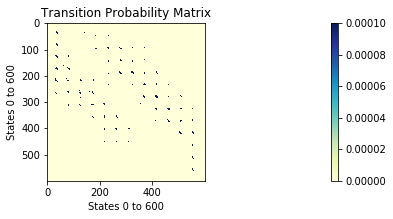

In [64]:
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 3

if useAspect == 1:
    figHeight = figWidth/aspectRatio

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.83, 0.73])

ax1.set_xlabel('States 0 to %d'%(horizontalAxis.shape[0] * verticalAxis.shape[0]))
ax1.set_ylabel('States 0 to %d'%(horizontalAxis.shape[0] * verticalAxis.shape[0]))

ax1.set_title('Transition Probability Matrix')

# iMShowHandler = ax1.imshow(tpMatrix,cmap=plt.get_cmap('YlGnBu'),vmax = 0.0001, extent=[0,399,0,399])
iMShowHandler = ax1.imshow(tpMatrix,cmap=plt.get_cmap('YlGnBu'),vmax = 0.0001)
ax4 = fig.add_axes([0.80, 0.15, 0.01, 0.73])
fig.colorbar(iMShowHandler,ax4)
fig.savefig("TrProbMatHalfHr.png")

In [16]:
opFile = dirToStore + 'TPM.npy'
np.save(opFile,tpMatrix)

In [17]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

In [18]:
#takes inital state vector
#and number of steps 
#uses transition probabilities to generate the path
def generate_path(vesselStart, noOfSteps):
    tpMat = np.linalg.matrix_power(tpMatrix,noOfSteps)
    #convert vesselStart into 
    return (vesselStart.T @ tpMat).flatten()

(762, 17)


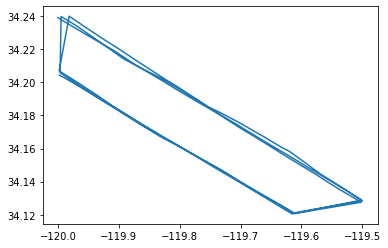

In [19]:
oneVessel = "../Data/M120_00_M190_50_34_12_34_24/MMSI/566952000_Sorted.csv"
oneVesselData,_ = aISDM.load_data_from_csv(oneVessel)
print(oneVesselData.shape)
oneVesselLon = oneVesselData['LON']
oneVesselLat = oneVesselData['LAT']
plt.plot(oneVesselLon,oneVesselLat)

In [20]:
oneVesselTime = oneVesselData['DateTime']
for i in range(oneVesselLon.shape[0]):
    print(oneVesselTime[i])

2017-01-02 02:04:50
2017-01-02 02:06:01
2017-01-02 02:07:11
2017-01-02 02:08:20
2017-01-02 02:09:30
2017-01-02 02:10:41
2017-01-02 02:11:50
2017-01-02 02:13:00
2017-01-02 02:14:11
2017-01-02 02:15:20
2017-01-02 02:16:21
2017-01-02 02:17:31
2017-01-02 02:18:40
2017-01-02 02:19:50
2017-01-02 02:21:00
2017-01-02 02:22:10
2017-01-02 02:23:20
2017-01-02 02:24:30
2017-01-02 02:25:41
2017-01-02 02:26:51
2017-01-02 02:28:01
2017-01-02 02:29:09
2017-01-02 02:30:20
2017-01-02 02:31:30
2017-01-02 02:32:40
2017-01-02 02:33:50
2017-01-02 02:35:00
2017-01-02 02:36:10
2017-01-02 02:37:20
2017-01-02 02:38:31
2017-01-02 02:39:40
2017-01-02 02:40:50
2017-01-02 02:41:51
2017-01-02 02:43:00
2017-01-02 02:44:10
2017-01-02 02:45:21
2017-01-02 02:46:31
2017-01-02 02:47:40
2017-01-02 02:48:50
2017-01-02 02:50:01
2017-01-02 02:51:11
2017-01-02 02:52:20
2017-01-02 02:53:21
2017-01-02 02:54:30
2017-01-02 02:55:41
2017-01-02 02:56:51
2017-01-02 02:58:01
2017-01-02 02:59:10
2017-01-02 03:00:21
2017-01-02 03:01:31


In [21]:
timeIntervalList = "../Data/M120_00_M190_50_34_12_34_24/TimeInterval/HalfHourIntvl1701To1702.txt"
timeWindows = [line.rstrip('\n') for line in open(timeIntervalList)]

In [22]:
#get the last instance of the position data 
#for one of the vessel
#and that can be used for the prediction
oneVesselLastData = pd.DataFrame()
#based on time stamps 
for timeSlot in timeWindows:
    temp = timeSlot.split(',')
    startTime = temp[0]
    endTime = temp[1]

    timelyDF = aISDM.filter_based_on_time_stamp(oneVesselData,'DateTime',startTime,endTime)
    oneVesselRows = timelyDF.shape[0]
    
    invertedTimelyDF = aISDM.inver_df(timelyDF)
    invertedTimelyDF = invertedTimelyDF.drop_duplicates(subset="MMSI")
    
    oneVesselLastData = oneVesselLastData.append(invertedTimelyDF, ignore_index = True)

In [23]:
print(oneVesselLastData)

         MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0   566952000  2017-01-02T02:29:09  34.18704 -119.91849  9.7  105.2    101.0   
1   566952000  2017-01-02T02:59:10  34.16577 -119.82437  9.6  102.8    100.0   
2   566952000  2017-01-02T03:29:10  34.14665 -119.73032  9.7  105.2    104.0   
3   566952000  2017-01-02T03:59:01  34.12650 -119.63697  9.7  104.4    104.0   
4   566952000  2017-01-02T04:07:10  34.12079 -119.61099  9.8  105.2    105.0   
5   566952000  2017-01-05T22:59:50  34.13857 -119.54273  6.2 -123.3    282.0   
6   566952000  2017-01-05T23:29:51  34.15269 -119.59874  5.5 -121.9    280.0   
7   566952000  2017-01-05T23:59:59  34.16530 -119.65319  5.6 -124.3    280.0   
8   566952000  2017-01-06T00:28:50  34.17661 -119.70700  5.7 -126.5    280.0   
9   566952000  2017-01-06T00:59:09  34.18780 -119.76462  5.6 -123.7    285.0   
10  566952000  2017-01-06T01:29:29  34.20048 -119.82097  6.0 -125.3    285.0   
11  566952000  2017-01-06T01:59:20  34.2

In [24]:
#divide the journey into two parts
#part 1 is from 0 to 4 included
#part 2 is from 5 to 13 included
oneVesselLastDataOne = oneVesselLastData.iloc[0:5,:]
oneVesselLastDataTwo = oneVesselLastData.iloc[5:,:]

In [25]:
print(oneVesselLastDataOne)

        MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  566952000  2017-01-02T02:29:09  34.18704 -119.91849  9.7  105.2    101.0   
1  566952000  2017-01-02T02:59:10  34.16577 -119.82437  9.6  102.8    100.0   
2  566952000  2017-01-02T03:29:10  34.14665 -119.73032  9.7  105.2    104.0   
3  566952000  2017-01-02T03:59:01  34.12650 -119.63697  9.7  104.4    104.0   
4  566952000  2017-01-02T04:07:10  34.12079 -119.61099  9.8  105.2    105.0   

     VesselName         IMO CallSign  VesselType                  Status  \
0  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
1  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
2  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
3  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
4  APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   

   Length  Width  Draft  Cargo            DateTime  
0   328.2   45.

In [26]:
print(oneVesselLastDataTwo)

         MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
5   566952000  2017-01-05T22:59:50  34.13857 -119.54273  6.2 -123.3    282.0   
6   566952000  2017-01-05T23:29:51  34.15269 -119.59874  5.5 -121.9    280.0   
7   566952000  2017-01-05T23:59:59  34.16530 -119.65319  5.6 -124.3    280.0   
8   566952000  2017-01-06T00:28:50  34.17661 -119.70700  5.7 -126.5    280.0   
9   566952000  2017-01-06T00:59:09  34.18780 -119.76462  5.6 -123.7    285.0   
10  566952000  2017-01-06T01:29:29  34.20048 -119.82097  6.0 -125.3    285.0   
11  566952000  2017-01-06T01:59:20  34.21193 -119.88023  6.3 -126.7    288.0   
12  566952000  2017-01-06T02:29:09  34.22696 -119.94099  6.3 -122.7    291.0   
13  566952000  2017-01-06T02:55:39  34.23985 -119.99474  6.1 -125.1    289.0   

      VesselName         IMO CallSign  VesselType                  Status  \
5   APL SAVANNAH  IMO9597513   9V9919      1004.0  under way using engine   
6   APL SAVANNAH  IMO9597513   9V9919      10

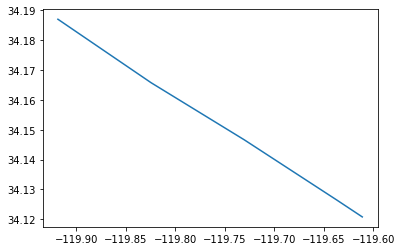

In [27]:
oneVesselLastDataOneLon = oneVesselLastDataOne["LON"]
oneVesselLastDataOneLat = oneVesselLastDataOne["LAT"]
plt.plot(oneVesselLastDataOneLon,oneVesselLastDataOneLat)

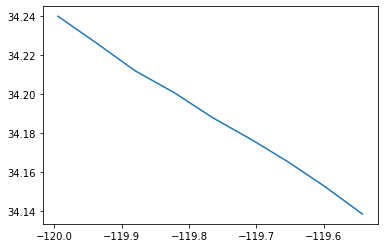

In [28]:
oneVesselLastDataTwoLon = oneVesselLastDataTwo["LON"]
oneVesselLastDataTwoLat = oneVesselLastDataTwo["LAT"]
plt.plot(oneVesselLastDataTwoLon,oneVesselLastDataTwoLat)

In [29]:
print(oneVesselLastDataTwoLon.shape)

(9,)


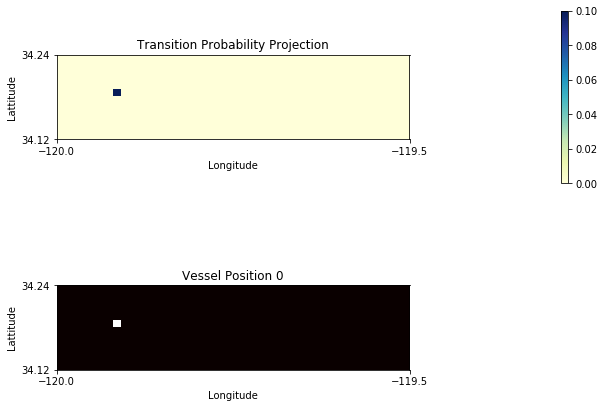

In [30]:
vesselState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataOneLon.iloc[i],oneVesselLastDataOneLat.iloc[i])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    vesselProbState = generate_path(vesselState,i)
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=5, interval=1000)

In [31]:
HTML(anim.to_html5_video())

In [32]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

In [33]:
anim.save('TPSeqOne.mp4', writer=writer)

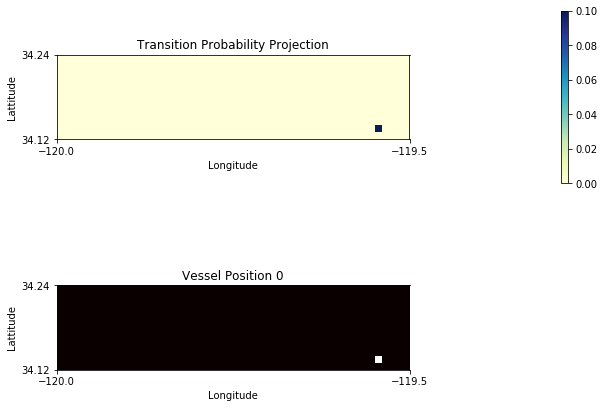

In [34]:
vesselState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 8

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.49, 0.30])
ax2 = fig.add_axes([0.1, 0.55, 0.49, 0.30])
ax4 = fig.add_axes([0.8, 0.55, 0.01, 0.30])

if useAspect == 1:
    figHeight = figWidth/aspectRatio

def animate(i):
    vesselCurrPos = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[i],oneVesselLastDataTwoLat.iloc[i])
    vesselCurrPos = np.reshape(vesselCurrPos,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    
    vesselCurrPos = np.flip(vesselCurrPos,axis=0)

    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Lattitude')
    titleStr = 'Vessel Position %d'%((i))
    ax1.set_title(titleStr)
    ax1.set_xticks([lonMin,lonMax])
    ax1.set_yticks([latMin,latMax])

    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Lattitude')
    ax2.set_title('Transition Probability Projection')
    ax2.set_xticks([lonMin,lonMax])
    ax2.set_yticks([latMin,latMax])

    ax1.imshow(vesselCurrPos,cmap=plt.get_cmap('hot'),extent=[lonMin,lonMax,latMin,latMax])
    #sequence of vessel states
    vesselProbState = generate_path(vesselState,i)
    vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
    vesselProbState = np.flip(vesselProbState,axis=0)
    
    iMShowHandler = ax2.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
    
    fig.colorbar(iMShowHandler,ax4)
    
anim = animation.FuncAnimation(fig, animate,frames=9, interval=1000)

In [35]:
HTML(anim.to_html5_video())

In [36]:
anim.save('TPSeqTwo.mp4', writer=writer)

308


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


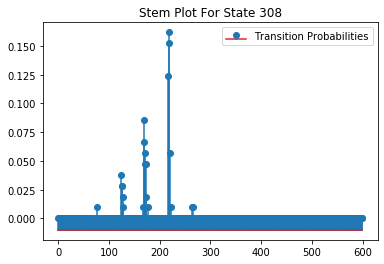

In [41]:
oneFirstState = get_index_from_lon_lat(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])
print(oneFirstState)
oneFirstStateProb = tpMatrix[oneFirstState,:]
plt.stem(oneFirstStateProb, bottom = -0.01, label = "Transition Probabilities")
plt.legend()
plt.title("Stem Plot For State %d"%(oneFirstState))
plt.savefig("StemPlotOne.png")

95


/home/jcharla/anaconda3/envs/jagir_ship_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


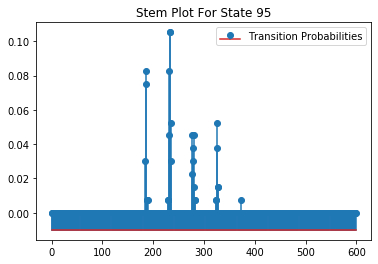

In [42]:
twoFirstState = get_index_from_lon_lat(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])
print(twoFirstState)
twoFirstStateProb = tpMatrix[twoFirstState,:]
plt.stem(twoFirstStateProb, bottom = -0.01, label = "Transition Probabilities")
plt.legend()
plt.title("Stem Plot For State %d"%(twoFirstState))
plt.savefig("StemPlotTwo.png")

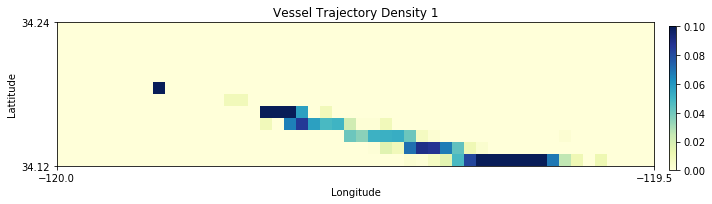

In [63]:
vesselState = get_vessel_init_status(oneVesselLastDataOneLon.iloc[0],oneVesselLastDataOneLat.iloc[0])

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 4

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.83, 0.73])
ax4 = fig.add_axes([0.95, 0.25, 0.01, 0.50])

if useAspect == 1:
    figHeight = figWidth/aspectRatio
    
vesselProbState = vesselState.copy()
for i in range(1,5):
    vesselProbState = vesselProbState + generate_path(vesselState,i)

vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
vesselProbState = np.flip(vesselProbState,axis=0)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
titleStr = 'Vessel Trajectory Density 1'
ax1.set_title(titleStr)
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
    
iMShowHandler = ax1.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
fig.colorbar(iMShowHandler,ax4)
fig.savefig('VesselTrajDen1.png')

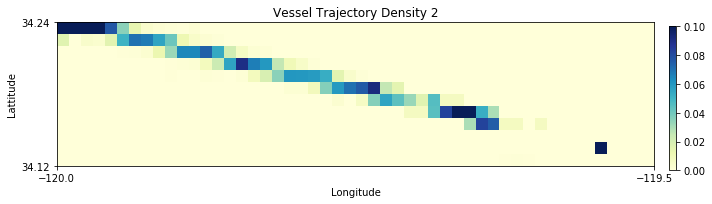

In [62]:
vesselState = get_vessel_init_status(oneVesselLastDataTwoLon.iloc[0],oneVesselLastDataTwoLat.iloc[0])

useAspect = 0
aspectRatio = 16.0/9.0
figWidth = 10
figHeight = 4

fig = plt.figure(figsize=(figWidth,figHeight))
ax1 = fig.add_axes([0.1, 0.15, 0.83, 0.73])
ax4 = fig.add_axes([0.95, 0.25, 0.01, 0.50])

if useAspect == 1:
    figHeight = figWidth/aspectRatio
    
vesselProbState = vesselState.copy()
for i in range(1,9):
    vesselProbState = vesselProbState + generate_path(vesselState,i)

vesselProbState = np.reshape(vesselProbState,(verticalAxis.shape[0],horizontalAxis.shape[0]))
vesselProbState = np.flip(vesselProbState,axis=0)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Lattitude')
titleStr = 'Vessel Trajectory Density 2'
ax1.set_title(titleStr)
ax1.set_xticks([lonMin,lonMax])
ax1.set_yticks([latMin,latMax])
    
iMShowHandler = ax1.imshow(vesselProbState,cmap=plt.get_cmap('YlGnBu'),extent=[lonMin,lonMax,latMin,latMax], vmax = 0.10)
fig.colorbar(iMShowHandler,ax4)
fig.savefig('VesselTrajDen2.png')